## Import Necessary Libraries

https://massdot-impact-crashes-vhb.opendata.arcgis.com/

In [ ]:
import pandas as pd
import numpy as np
from io import StringIO
import requests
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_recall_fscore_support, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git

  Cloning https://github.com/scikit-optimize/scikit-optimize.git to /tmp/pip-req-build-2gkfuprv
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-optimize/scikit-optimize.git /tmp/pip-req-build-2gkfuprv
  Resolved https://github.com/scikit-optimize/scikit-optimize.git to commit a2369ddbc332d16d8ff173b12404b03fea472492
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from skopt import BayesSearchCV

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

## Load the Dataset

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the 2022 and 2023 datasets
file_path_2022 = '/content/drive/MyDrive/BU/Fall 2024/CS506/CS506_Final_Project/Dataset/2022/2022_Crashes.csv'
file_path_2023 = '/content/drive/MyDrive/BU/Fall 2024/CS506/CS506_Final_Project/Dataset/2023/2023_Crashes.csv'

df_2022 = pd.read_csv(file_path_2022)
df_2023 = pd.read_csv(file_path_2023)

merged_df = pd.concat([df_2022, df_2023], axis=0, ignore_index=True)

<ipython-input-134-94e4a376aece>:5: DtypeWarning: Columns (66) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2022 = pd.read_csv(file_path_2022)
<ipython-input-134-94e4a376aece>:6: DtypeWarning: Columns (66,115,116,117,118,119,120,121) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2023 = pd.read_csv(file_path_2023)


## Cleaning the Data

### Delete Columns with No Values, Repetitive and Unnecessary Information

In [ ]:
columns_to_drop = [
    'CRASH_NUMB', 'CRASH_STATUS', 'MAX_INJR_SVRTY_CL', 'MOST_HRMFL_EVT_CL',
    'NUMB_NONFATAL_INJR', 'NUMB_FATAL_INJR', 'POLC_AGNCY_TYPE_DESCR', 'VEHC_MNVR_ACTN_CL', 'NUMB_VEHC',
    'VEHC_TRVL_DIRC_CL', 'VEHC_SEQ_EVENTS_CL', 'FIRST_HRMF_EVENT_DESCR', 'DRVR_CNTRB_CIRC_CL',
    'FIRST_HRMF_EVENT_LOC_DESCR', 'YEAR', 'CURB', 'OBJECTID', 'STREET_NUMB', 'RDWY', 'MANR_COLL_DESCR',
    'DIST_DIRC_FROM_INT', 'NEAR_INT_RDWY', 'MM_RTE', 'DIST_DIRC_MILEMARKER', 'EXIT_RTE', 'VEHC_CONFIG_CL',
    'DIST_DIRC_EXIT', 'EXIT_NUMB', 'DIST_DIRC_LANDMARK', 'LANDMARK', 'TRAFY_DESCR_DESCR',
    'JURISDICTN', 'NON_MTRST_TYPE_CL', 'NON_MTRST_ACTN_CL', 'NON_MTRST_LOC_CL', 'IS_GEOCODED',
    'GEOCODING_METHOD_NAME', 'RMV_DOC_IDS', 'X', 'Y', 'LAT', 'LON', 'CRASH_RPT_IDS', 'CRASH_SEVERITY_DESCR',
    'AGE_NONMTRST_YNGST', 'AGE_NONMTRST_OLDEST', 'DRVR_DISTRACTED_CL', 'DISTRICT_NUM','MILEMARKER',
    'RPA_ABBR', 'VEHC_EMER_USE_CL', 'VEHC_TOWED_FROM_SCENE_CL', 'FMCSA_RPTBL_CL', 'FMCSA_RPTBL',
    'HIT_RUN_DESCR', 'LCLTY_NAME', 'ROAD_CNTRB_DESCR', 'SCHL_BUS_RELD_DESCR',
    'TRAF_CNTRL_DEVC_FUNC_DESCR', 'AADT', 'AADT_YEAR', 'WORK_ZONE_RELD_DESCR', 'PK_PCT_SUT',
    'AV_PCT_SUT', 'PK_PCT_CT', 'AV_PCT_CT', 'TRUCK_RTE', 'LT_SIDEWLK', 'RT_SIDEWLK',
    'SHLDR_LT_W', 'SHLDR_LT_T', 'SURFACE_WD', 'SURFACE_TP', 'SHLDR_RT_W', 'SHLDR_RT_T',
    'MED_WIDTH', 'NUM_LANES', 'OPP_LANES', 'MED_TYPE', 'URBAN_TYPE', 'FACILITY', 'PEAK_LANE',
    'SPEED_LIM', 'STREETNAME', 'FROMSTREETNAME', 'TOSTREETNAME', 'CITY', 'STRUCT_CND',
    'AADT_DERIV', 'STATN_NUM', 'OP_DIR_SL', 'SHLDR_UL_T', 'SHLDR_UL_W', 'F_F_CLASS', 'TRAFFIC_CONTROL_TYPE_DESCR', 'NON_MTRST_ORIGIN_DEST_CL',
    'NON_MTRST_CNTRB_CIRC_CL', 'NON_MTRST_DISTRACTED_BY_CL', 'NON_MTRST_ALC_SUSPD_TYPE_CL',
    'NON_MTRST_DRUG_SUSPD_TYPE_CL', 'NON_MTRST_EVENT_SEQ_CL', 'SHAPE', 'URBAN_AREA', 'URBAN_LOC_TYPE', 'FD_AID_RTE'
]

#df_2022 = df_2022.drop(columns=columns_to_drop)
#df_2023 = df_2023.drop(columns=columns_to_drop)

merged_df = merged_df.drop(columns=columns_to_drop)

In [ ]:
print(merged_df.head())

  CITY_TOWN_NAME CRASH_DATE_TEXT CRASH_TIME_2          CRASH_DATETIME  \
0        METHUEN      01/01/2022     12:11:00  2022/01/01 12:11:00+00   
1        HOLYOKE      01/01/2022     05:08:00  2022/01/01 05:08:00+00   
2        HOLYOKE      01/01/2022     12:20:00  2022/01/01 00:20:00+00   
3        EVERETT      01/01/2022     11:34:00  2022/01/01 11:34:00+00   
4        WAREHAM      01/01/2022     04:31:00  2022/01/01 16:31:00+00   

  CRASH_HOUR                AMBNT_LIGHT_DESCR WEATH_COND_DESCR  \
0   12:00:00                         Daylight        Rain/Rain   
1   05:00:00           Dark - lighted roadway     Cloudy/Other   
2   12:00:00  Dark - unknown roadway lighting           Cloudy   
3   11:00:00                         Daylight        Rain/Rain   
4   04:00:00           Dark - lighted roadway             Rain   

  ROAD_SURF_COND_DESCR   RDWY_JNCT_TYPE_DESCR TRAF_CNTRL_DEVC_TYPE_DESCR  \
0                  Wet  Four-way intersection                 Stop signs   
1           

### Drop Columns with Missing Data


In [ ]:
# Drop columns with missing values
merged_df.dropna(inplace=True)

#Check to see if there are any missing values
merged_df.isnull().sum()

,0
CITY_TOWN_NAME,0
CRASH_DATE_TEXT,0
CRASH_TIME_2,0
CRASH_DATETIME,0
CRASH_HOUR,0
AMBNT_LIGHT_DESCR,0
WEATH_COND_DESCR,0
ROAD_SURF_COND_DESCR,0
RDWY_JNCT_TYPE_DESCR,0
TRAF_CNTRL_DEVC_TYPE_DESCR,0


## Feature Engineering

### Identify Possible Values (Categories) for Each Categorical Column

In [ ]:
categorical_columns = merged_df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    print(f"Unique values in '{column}':", df_2022[column].unique())

Unique values in 'CITY_TOWN_NAME': ['METHUEN' 'HOLYOKE' 'EVERETT' 'WAREHAM' 'NORTH ATTLEBOROUGH' 'NANTUCKET'
 'DEDHAM' 'BRAINTREE' 'FALL RIVER' 'BERNARDSTON' 'BILLERICA' 'DARTMOUTH'
 'BEDFORD' 'FITCHBURG' 'WALPOLE' 'NORTH ADAMS' 'NORTON' 'MIDDLEBOROUGH'
 'HUDSON' 'FOXBOROUGH' 'WEST BRIDGEWATER' 'EASTON' 'WINTHROP'
 'WESTBOROUGH' 'HAVERHILL' 'TAUNTON' 'BEVERLY' 'ATTLEBORO' 'DRACUT'
 'DOVER' 'CHELSEA' 'NEW BEDFORD' 'WALTHAM' 'FAIRHAVEN' 'HOPKINTON'
 'BOURNE' 'WILBRAHAM' 'SHARON' 'HULL' 'READING' 'SALISBURY' 'MEDFORD'
 'YARMOUTH' 'SEEKONK' 'WESTWOOD' 'MANSFIELD' 'LAKEVILLE' 'ABINGTON'
 'PLYMOUTH' 'ARLINGTON' 'MARLBOROUGH' 'BLACKSTONE' 'ANDOVER' 'WELLESLEY'
 'MARION' 'WAKEFIELD' 'MIDDLETON' 'MANCHESTER' 'STOCKBRIDGE' 'SOUTHWICK'
 'REVERE' 'CHICOPEE' 'PITTSFIELD' 'CHATHAM' 'GRANBY' 'MEDWAY' 'FRANKLIN'
 'ASHBURNHAM' 'BOYLSTON' 'REHOBOTH' 'LYNN' 'WESTON' 'BOSTON' 'FRAMINGHAM'
 'CHARLTON' 'SWANSEA' 'HARVARD' 'FALMOUTH' 'MILTON' 'QUINCY' 'SANDWICH'
 'GRAFTON' 'UPTON' 'STURBRIDGE' 'HUNTINGTON' '

### Filter Observations for Greater Boston Cities (within Massachusetts)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Step 1: List of Greater Boston area city and town names
greater_boston_cities = [
    'BOSTON', 'CHELSEA', 'REVERE', 'WINTHROP',  # Suffolk County
    'ARLINGTON', 'BEDFORD', 'BELMONT', 'BURLINGTON', 'CAMBRIDGE', 'EVERETT', 'FRAMINGHAM', 'LEXINGTON', 'LINCOLN',
    'MALDEN', 'MEDFORD', 'MELROSE', 'NATICK', 'NEWTON', 'NORTH READING', 'READING', 'SOMERVILLE', 'STONEHAM',
    'WAKEFIELD', 'WALTHAM', 'WATERTOWN', 'WAYLAND', 'WESTON', 'WILMINGTON', 'WINCHESTER', 'WOBURN',  # Middlesex County
    'BRAINTREE', 'BROOKLINE', 'CANTON', 'DEDHAM', 'FOXBOROUGH', 'FRANKLIN', 'MEDFIELD', 'MILTON', 'NEEDHAM',
    'NORWOOD', 'QUINCY', 'RANDOLPH', 'SHARON', 'WALPOLE', 'WELLESLEY', 'WESTWOOD', 'WEYMOUTH',  # Norfolk County
    'ANDOVER', 'BEVERLY', 'DANVERS', 'GLOUCESTER', 'HAVERHILL', 'LAWRENCE', 'LYNN', 'MARBLEHEAD', 'PEABODY',
    'SALEM', 'SAUGUS', 'SWAMPSCOTT', 'TOPSFIELD',  # Essex County
    'ABINGTON', 'HINGHAM', 'HULL', 'MARSHFIELD', 'NORWELL', 'ROCKLAND', 'SCITUATE', 'WHITMAN'  # Plymouth County
]

# Step 2: Filter the DataFrame
merged_df = merged_df[merged_df['CITY_TOWN_NAME'].isin(greater_boston_cities)]

# Step 3: Encode the CITY_TOWN_NAME column
label_encoder = LabelEncoder()
merged_df['CITY_TOWN_NAME_ENCODED'] = label_encoder.fit_transform(merged_df['CITY_TOWN_NAME'])

# After encoding city names
city_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("City to Label Mapping:", city_mapping)

# Save city_mapping
import joblib
joblib.dump(city_mapping, 'city_mapping.joblib')

City to Label Mapping: {'ABINGTON': 0, 'ANDOVER': 1, 'ARLINGTON': 2, 'BEDFORD': 3, 'BELMONT': 4, 'BEVERLY': 5, 'BOSTON': 6, 'BRAINTREE': 7, 'BROOKLINE': 8, 'BURLINGTON': 9, 'CAMBRIDGE': 10, 'CANTON': 11, 'CHELSEA': 12, 'DANVERS': 13, 'DEDHAM': 14, 'EVERETT': 15, 'FOXBOROUGH': 16, 'FRAMINGHAM': 17, 'FRANKLIN': 18, 'GLOUCESTER': 19, 'HAVERHILL': 20, 'HINGHAM': 21, 'HULL': 22, 'LAWRENCE': 23, 'LEXINGTON': 24, 'LINCOLN': 25, 'LYNN': 26, 'MALDEN': 27, 'MARBLEHEAD': 28, 'MARSHFIELD': 29, 'MEDFIELD': 30, 'MEDFORD': 31, 'MELROSE': 32, 'MILTON': 33, 'NATICK': 34, 'NEEDHAM': 35, 'NEWTON': 36, 'NORTH READING': 37, 'NORWELL': 38, 'NORWOOD': 39, 'PEABODY': 40, 'QUINCY': 41, 'RANDOLPH': 42, 'READING': 43, 'REVERE': 44, 'ROCKLAND': 45, 'SALEM': 46, 'SAUGUS': 47, 'SCITUATE': 48, 'SHARON': 49, 'SOMERVILLE': 50, 'STONEHAM': 51, 'SWAMPSCOTT': 52, 'TOPSFIELD': 53, 'WAKEFIELD': 54, 'WALPOLE': 55, 'WALTHAM': 56, 'WATERTOWN': 57, 'WAYLAND': 58, 'WELLESLEY': 59, 'WESTON': 60, 'WESTWOOD': 61, 'WEYMOUTH': 62, '

<ipython-input-139-5f6f52fde7a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['CITY_TOWN_NAME_ENCODED'] = label_encoder.fit_transform(merged_df['CITY_TOWN_NAME'])


['city_mapping.joblib']

### Combine Crash Date and Time and Generate Categories for More Time-Related Indicators

### Date and Time-Based Feature Engineering

In [ ]:
def add_holiday_and_datetime_features(df, year):
    # Check if the column 'CRASH_DATETIME' exists
    if 'CRASH_DATETIME' in df.columns:
        df['CRASH_DATETIME'] = pd.to_datetime(df['CRASH_DATETIME'], errors='coerce')
    else:
        raise KeyError("'CRASH_DATETIME' column not found. Update the function to use available date/time columns.")

    # Extract date-related features
    df['CRASH_HOUR'] = df['CRASH_DATETIME'].dt.hour
    df['DAY_OF_WEEK'] = df['CRASH_DATETIME'].dt.dayofweek  # Monday=0, Sunday=6
    df['IS_WEEKEND'] = df['DAY_OF_WEEK'].apply(lambda x: 1 if x >= 5 else 0)
    df['IS_NIGHT'] = df['CRASH_HOUR'].apply(lambda x: 1 if (x >= 20 or x < 6) else 0)

    # Add holiday indicator
    us_holidays = holidays.US(years=year)
    df['IS_HOLIDAY'] = df['CRASH_DATETIME'].apply(lambda x: 1 if x.date() in us_holidays else 0)

    return df

In [ ]:
def add_rush_hour_indicator(df):
    # Ensure 'CRASH_HOUR' is numeric
    df['CRASH_HOUR'] = pd.to_numeric(df['CRASH_HOUR'], errors='coerce')

    # Add a new column 'IS_RUSH_HOUR' (1 if the time is during rush hour, 0 otherwise)
    df['IS_RUSH_HOUR'] = df['CRASH_HOUR'].apply(
        lambda x: 1 if pd.notnull(x) and ((6 <= x < 10) or (15 <= x < 19)) else 0
    )
    return df

### Segment by Time and Weather

In [ ]:
# Define time segments based on crash hour
def time_of_day(hour):
    # Convert hour to a numeric type before comparison
    hour = pd.to_numeric(hour, errors='coerce')
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

# Apply the function to create the `TIME_OF_DAY` column
merged_df['TIME_OF_DAY'] = merged_df['CRASH_HOUR'].apply(time_of_day)

# Encode the `TIME_OF_DAY` column to numeric values
time_of_day_mapping = {
    'Morning': 0,
    'Afternoon': 1,
    'Evening': 2,
    'Night': 3
}
merged_df['TIME_OF_DAY_ENCODED'] = merged_df['TIME_OF_DAY'].map(time_of_day_mapping)

# Optionally, drop the original `TIME_OF_DAY` column
merged_df = merged_df.drop(columns=['TIME_OF_DAY'])

### Engineer Interaction Terms for Both Datasets

### Generate Speed Limit Ranges and Calculate Accident Frequency

In [ ]:
def categorize_speed_limit(speed):
    if pd.isnull(speed):
        return 'Unknown'  # Handle missing values
    elif speed < 30:
        return '<30 mph'
    elif 30 <= speed <= 50:
        return '30-50 mph'
    else:
        return '>50 mph'

# Apply the function to create the 'SPEED_LIMIT_RANGE' column for both datasets
merged_df['SPEED_LIMIT_RANGE'] = merged_df['SPEED_LIMIT'].apply(categorize_speed_limit)

# Calculate accident frequencies within each range for 2022
accidents_by_speed_range= merged_df['SPEED_LIMIT_RANGE'].value_counts().sort_index()

In [ ]:
# Define a mapping for SPEED_LIMIT_RANGE
speed_limit_mapping = {
    '<30 mph': 0,
    '30-50 mph': 1,
    '>50 mph': 2,
    'Unknown': -1  # You can choose a value for 'Unknown' or handle it differently
}

# Apply the mapping to the SPEED_LIMIT_RANGE column
merged_df['SPEED_LIMIT_ENCODED'] = merged_df['SPEED_LIMIT_RANGE'].map(speed_limit_mapping)

# Save speed limit mapping
joblib.dump(speed_limit_mapping, 'speed_limit_mapping.joblib')


['speed_limit_mapping.joblib']

### Simplify Weather Conditions

In [ ]:
# Simplify and Encode Weather conditions

# Step 1: Define a function to simplify and encode weather conditions
def simplify_and_encode_weather(df):
    # Simplify weather conditions
    df['WEATHER_SIMPLIFIED'] = df['WEATH_COND_DESCR'].apply(lambda x:
        'Clear' if 'Clear' in str(x) else
        'Rain' if 'Rain' in str(x) else
        'Snow' if 'Snow' in str(x) else
        'Fog/Smoke' if 'Fog' in str(x) or 'smog' in str(x) else
        'Hail' if 'Sleet' in str(x) or 'hail' in str(x) or 'freezing rain' in str(x) else
        'Wind' if 'Severe crosswinds' in str(x) else
        'Blowing Sand/Snow' if 'Blowing sand' in str(x) else
        'Unknown' if 'Unknown' in str(x) or 'Not Reported' in str(x) else
        'Other'
    )

    # Step 2: Encode the simplified weather conditions
    label_encoder = LabelEncoder()
    df['WEATHER_SIMPLIFIED_ENCODED'] = label_encoder.fit_transform(df['WEATHER_SIMPLIFIED'])

    # Step 3: Print the mapping of weather conditions to encoded labels
    weather_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Weather Condition to Label Mapping:", weather_mapping)

    return df

# Step 4: Apply the function to the merged DataFrame
merged_df = simplify_and_encode_weather(merged_df)

Weather Condition to Label Mapping: {'Blowing Sand/Snow': 0, 'Clear': 1, 'Fog/Smoke': 2, 'Hail': 3, 'Other': 4, 'Rain': 5, 'Snow': 6, 'Unknown': 7, 'Wind': 8}


In [ ]:
columns_to_clean = [
    'WEATHER_SIMPLIFIED', 'AMBNT_LIGHT_DESCR',
    'ROAD_SURF_COND_DESCR', 'RDWY_JNCT_TYPE_DESCR', 'TRAF_CNTRL_DEVC_TYPE_DESCR'
]

# Replace 'Unknown', 'Not reported', and NaN with None, then drop rows with any None values in key columns
merged_df = merged_df.replace(['Unknown', 'Not reported', 'Reported but invalid'], None).dropna(subset=columns_to_clean)

### Encode Road Conditions

In [ ]:
road_surf_cond_mapping = {
    'Wet': 0,
    'Dry': 1,
    'Ice': 2,
    'Snow': 3,
    'Slush': 4,
    'Other': 5,
    'Sand, mud, dirt, oil, gravel': 6,
    'Water (standing, moving)': 7
}

# Apply the mapping to the ROAD_SURF_COND_DESCR column
merged_df['ROAD_SURF_COND_ENCODED'] = merged_df['ROAD_SURF_COND_DESCR'].map(road_surf_cond_mapping)

# Save road surface condition mapping
joblib.dump(road_surf_cond_mapping, 'road_surf_cond_mapping.joblib')

['road_surf_cond_mapping.joblib']

### Create Interaction Terms

In [ ]:
# Add holiday and datetime features
merged_df = add_holiday_and_datetime_features(merged_df, 2022) # Changed df_2022 to merged_df

# Add rush hour indicator
merged_df = add_rush_hour_indicator(merged_df) # Changed df_2022 to merged_df

# Verify that 'IS_RUSH_HOUR' exists
if 'IS_RUSH_HOUR' not in merged_df.columns:
    raise KeyError("'IS_RUSH_HOUR' column is missing. Ensure the function is correctly applied.")

# Create interaction terms
merged_df['WEATHER_RUSH_HOUR'] = merged_df['WEATHER_SIMPLIFIED'] + "_" + merged_df['IS_RUSH_HOUR'].astype(str)
merged_df['WEATHER_NIGHT'] = merged_df['WEATHER_SIMPLIFIED'] + "_" + merged_df['IS_NIGHT'].astype(str)
merged_df['WEATHER_WEEKEND'] = merged_df['WEATHER_SIMPLIFIED'] + "_" + merged_df['IS_WEEKEND'].astype(str)

### Create Interaction Terms for Speed Limit Ranges and Weather

In [ ]:
# merged_df['SPEED_WEATHER'] = merged_df['SPEED_LIMIT_RANGE'] + "_" + merged_df['WEATHER_SIMPLIFIED']

# # More interaction terms
# merged_df['TIME_WEATHER'] = merged_df['TIME_OF_DAY_ENCODED'] + "_" + merged_df['WEATHER_SIMPLIFIED']

# merged_df['HOLIDAY_RUSH'] = merged_df['IS_HOLIDAY'].astype(str) + "_" + merged_df['IS_RUSH_HOUR'].astype(str)

# # Visualize the interaction effect for 2022
# plt.figure(figsize=(12, 6))
# merged_df['SPEED_WEATHER'].value_counts().plot(kind='bar')
# plt.title("Accidents by Speed Limit and Weather Condition")
# plt.xlabel("Speed Limit Range and Weather Condition")
# plt.ylabel("Number of Accidents")
# plt.xticks(rotation=45)
# plt.show()

## Preliminary Visualizations

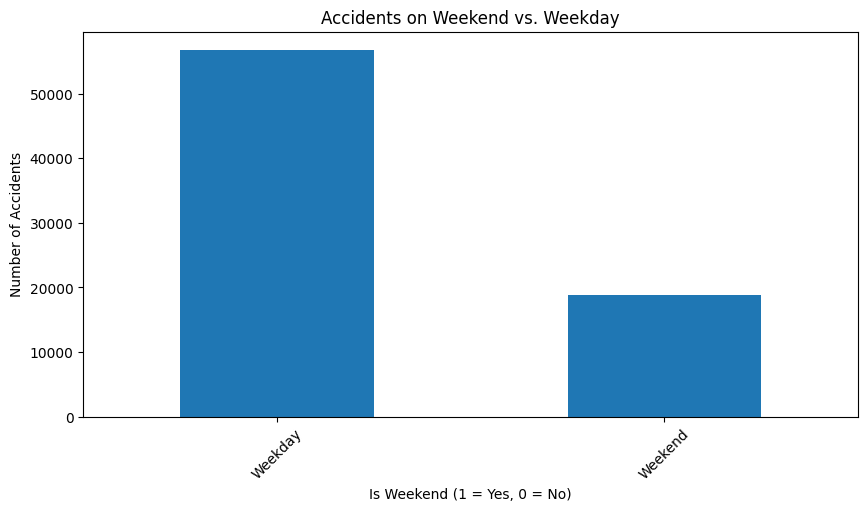

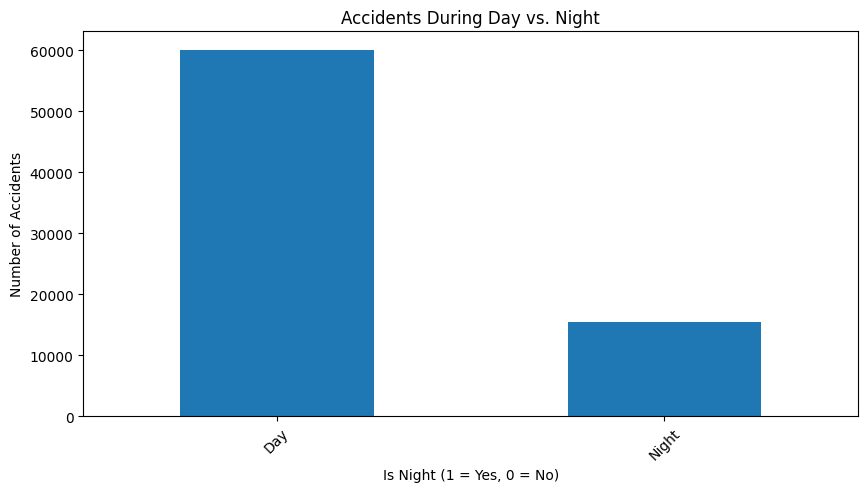

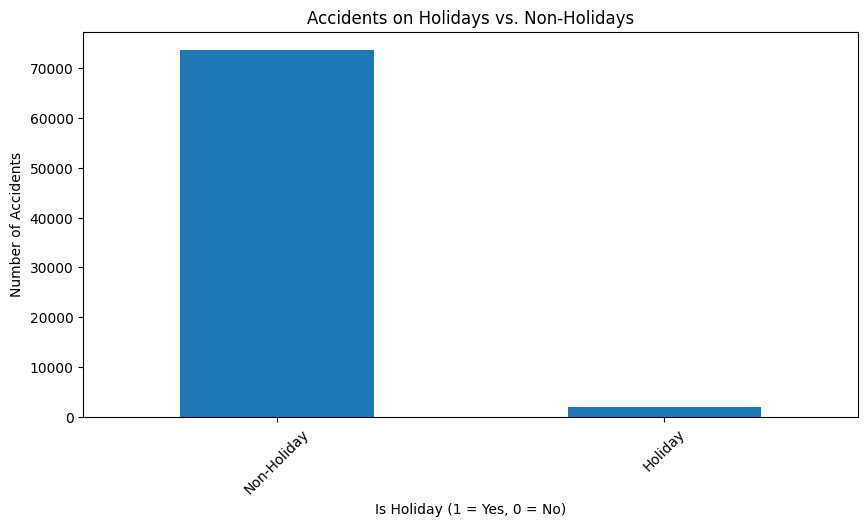

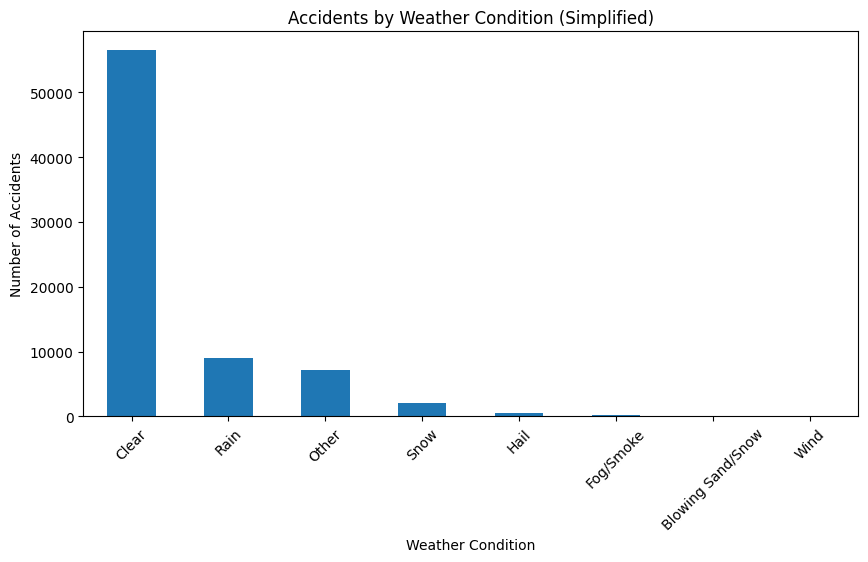

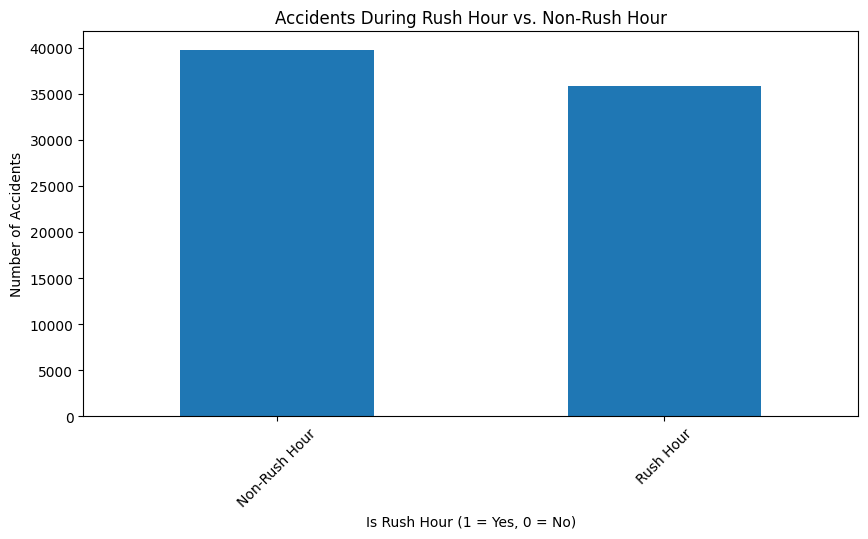

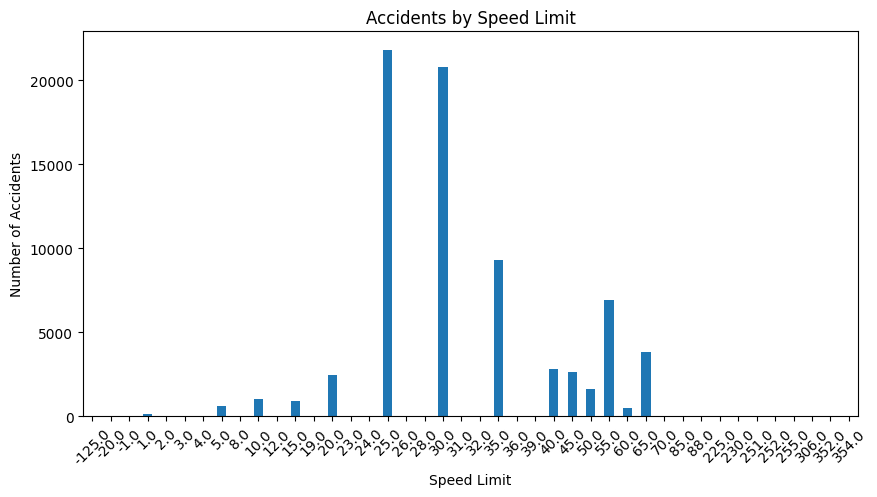

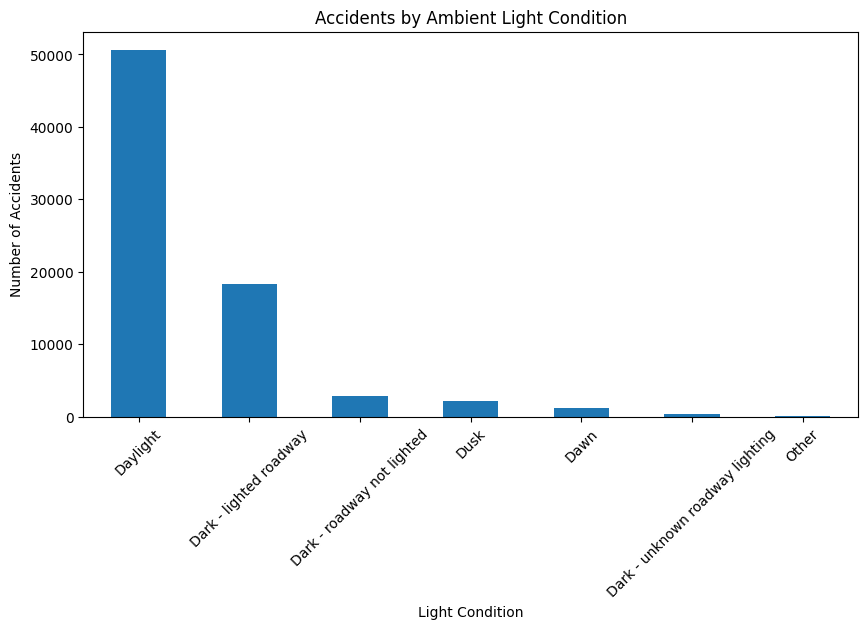

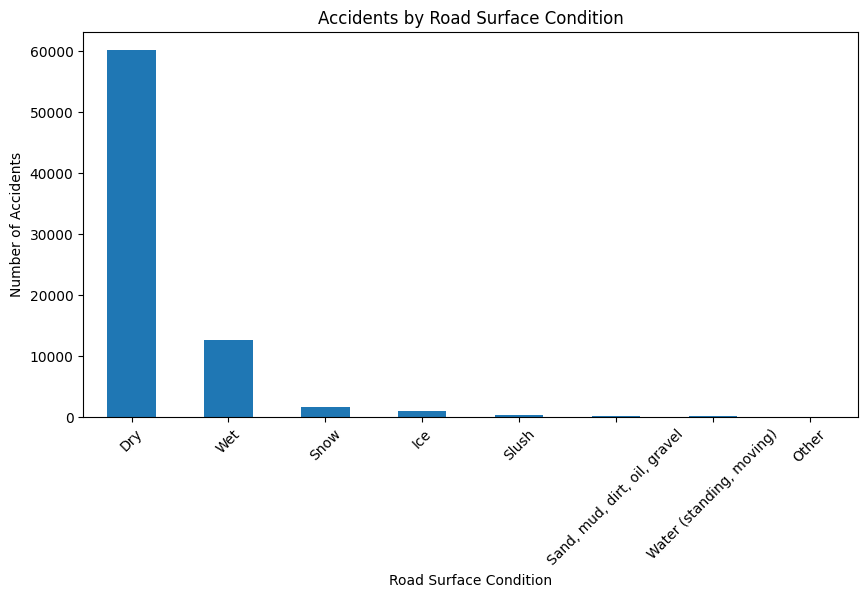

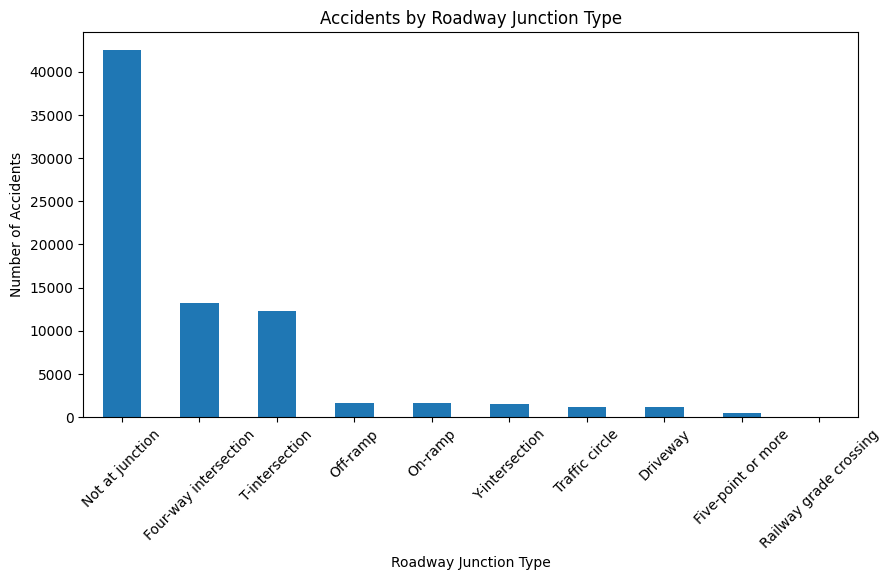

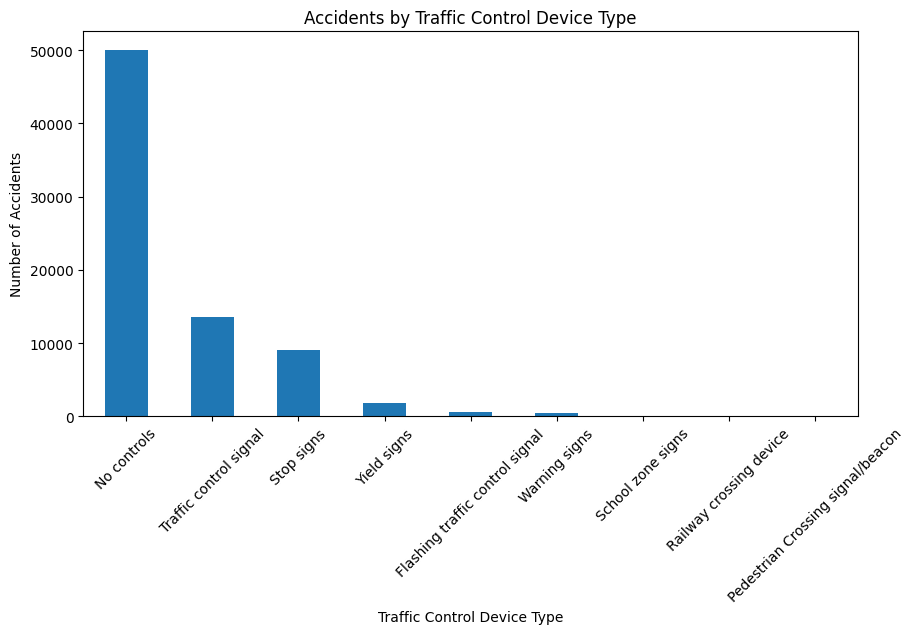

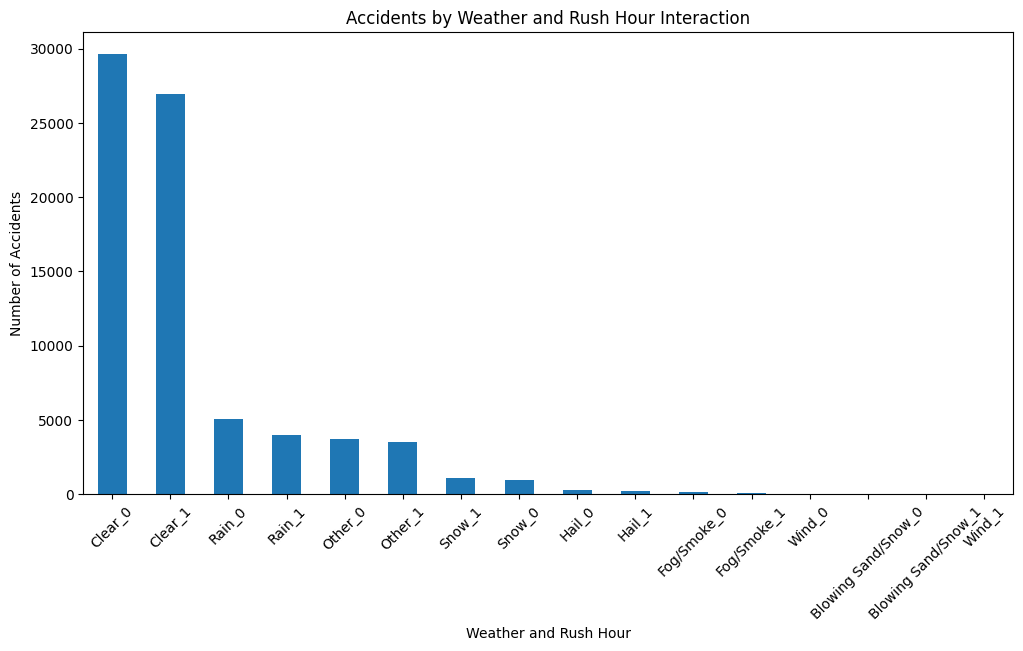

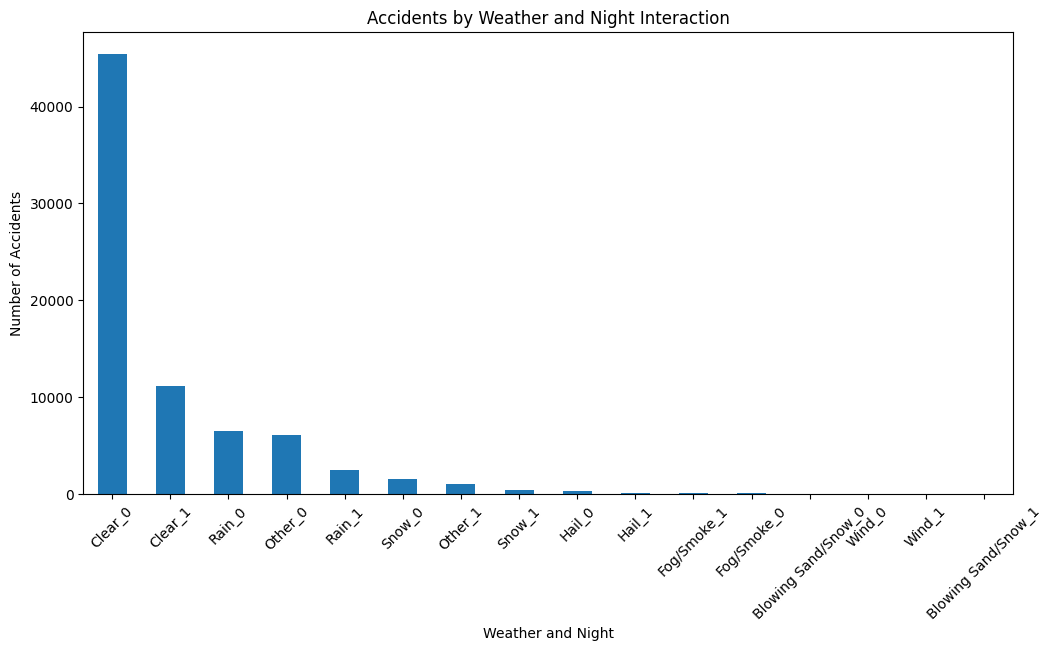

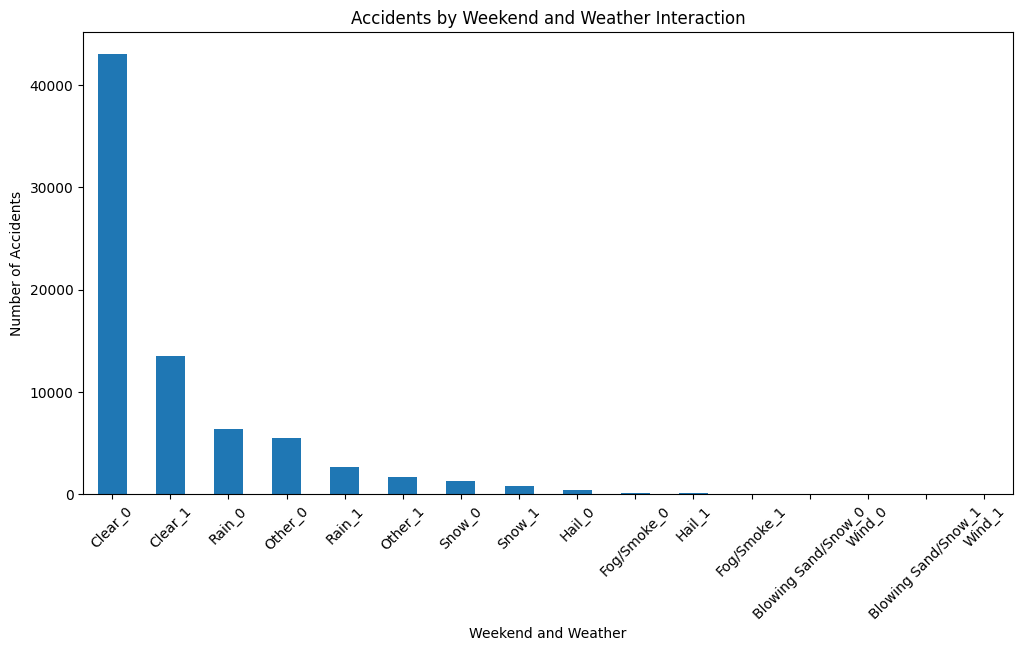

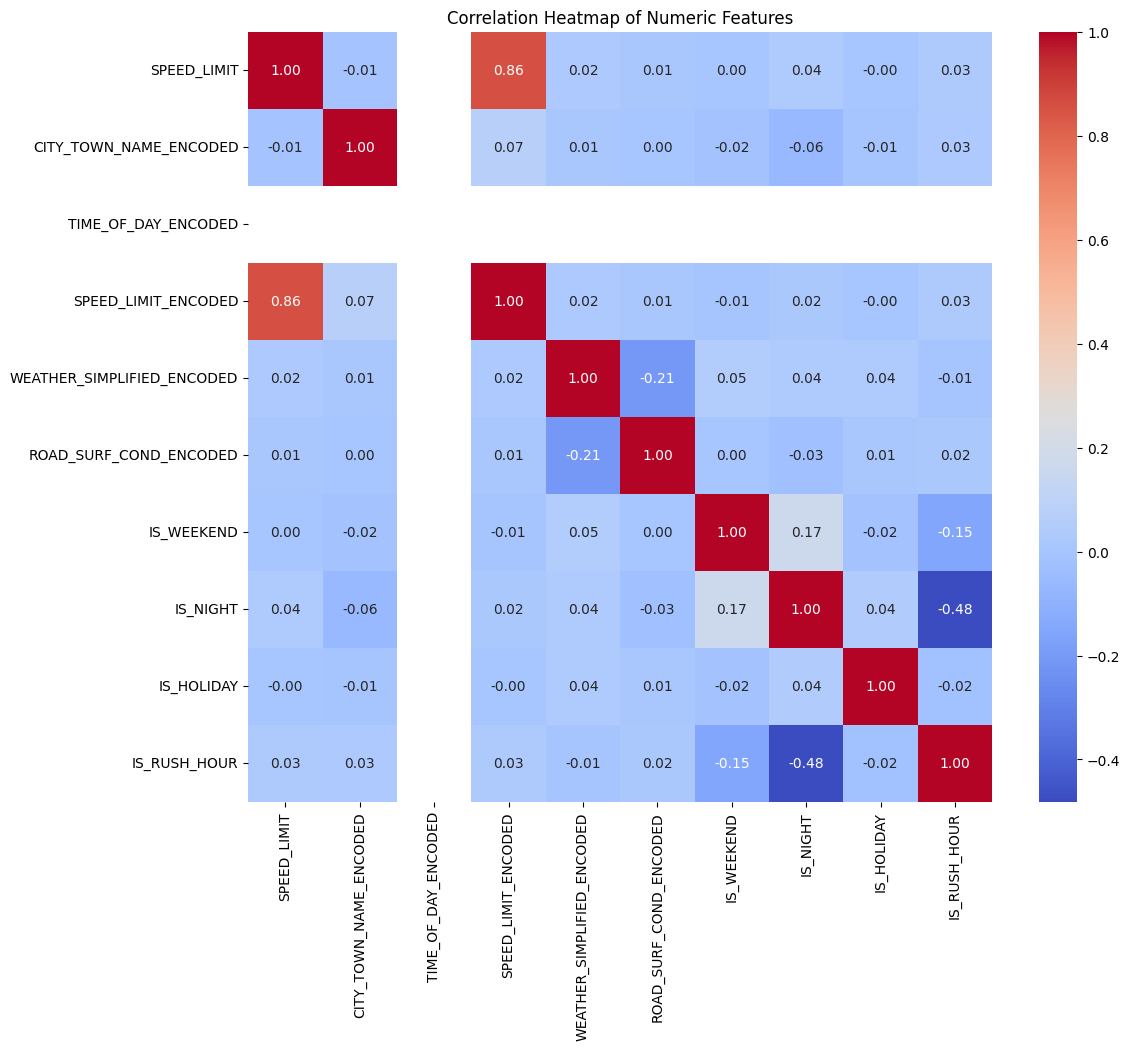

In [ ]:
def visualize_dataset(df):
    # 1. Accidents by Weekend vs. Weekday
    df['IS_WEEKEND'].value_counts().plot(kind='bar', figsize=(10, 5))
    plt.title("Accidents on Weekend vs. Weekday")
    plt.xlabel("Is Weekend (1 = Yes, 0 = No)")
    plt.ylabel("Number of Accidents")
    plt.xticks(ticks=[0, 1], labels=['Weekday', 'Weekend'], rotation=45)
    plt.show()

    # 2. Accidents During Day vs. Night
    df['IS_NIGHT'].value_counts().plot(kind='bar', figsize=(10, 5))
    plt.title("Accidents During Day vs. Night")
    plt.xlabel("Is Night (1 = Yes, 0 = No)")
    plt.ylabel("Number of Accidents")
    plt.xticks(ticks=[0, 1], labels=['Day', 'Night'], rotation=45)
    plt.show()

    # 3. Accidents on Holidays vs. Non-Holidays
    df['IS_HOLIDAY'].value_counts().plot(kind='bar', figsize=(10, 5))
    plt.title("Accidents on Holidays vs. Non-Holidays")
    plt.xlabel("Is Holiday (1 = Yes, 0 = No)")
    plt.ylabel("Number of Accidents")
    plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'], rotation=45)
    plt.show()

    # 4. Accidents by Weather Condition (Simplified)
    df['WEATHER_SIMPLIFIED'].value_counts().plot(kind='bar', figsize=(10, 5))
    plt.title("Accidents by Weather Condition (Simplified)")
    plt.xlabel("Weather Condition")
    plt.ylabel("Number of Accidents")
    plt.xticks(rotation=45)
    plt.show()

    # 5. Accidents During Rush Hour vs. Non-Rush Hour
    df['IS_RUSH_HOUR'].value_counts().plot(kind='bar', figsize=(10, 5))
    plt.title("Accidents During Rush Hour vs. Non-Rush Hour")
    plt.xlabel("Is Rush Hour (1 = Yes, 0 = No)")
    plt.ylabel("Number of Accidents")
    plt.xticks(ticks=[0, 1], labels=['Non-Rush Hour', 'Rush Hour'], rotation=45)
    plt.show()

    # 6. Accidents by Speed Limit
    if 'SPEED_LIMIT' in df.columns:
        df['SPEED_LIMIT'].value_counts().sort_index().plot(kind='bar', figsize=(10, 5))
        plt.title("Accidents by Speed Limit")
        plt.xlabel("Speed Limit")
        plt.ylabel("Number of Accidents")
        plt.xticks(rotation=45)
        plt.show()

    # 7. Accidents by Light Condition
    if 'AMBNT_LIGHT_DESCR' in df.columns:
        df['AMBNT_LIGHT_DESCR'].value_counts().plot(kind='bar', figsize=(10, 5))
        plt.title("Accidents by Ambient Light Condition")
        plt.xlabel("Light Condition")
        plt.ylabel("Number of Accidents")
        plt.xticks(rotation=45)
        plt.show()

    # 8. Accidents by Road Surface Condition
    if 'ROAD_SURF_COND_DESCR' in df.columns:
        df['ROAD_SURF_COND_DESCR'].value_counts().plot(kind='bar', figsize=(10, 5))
        plt.title("Accidents by Road Surface Condition")
        plt.xlabel("Road Surface Condition")
        plt.ylabel("Number of Accidents")
        plt.xticks(rotation=45)
        plt.show()

    # 9. Accidents by Roadway Junction Type
    if 'RDWY_JNCT_TYPE_DESCR' in df.columns:
        df['RDWY_JNCT_TYPE_DESCR'].value_counts().plot(kind='bar', figsize=(10, 5))
        plt.title("Accidents by Roadway Junction Type")
        plt.xlabel("Roadway Junction Type")
        plt.ylabel("Number of Accidents")
        plt.xticks(rotation=45)
        plt.show()

    # 10. Accidents by Traffic Control Device Type
    if 'TRAF_CNTRL_DEVC_TYPE_DESCR' in df.columns:
        df['TRAF_CNTRL_DEVC_TYPE_DESCR'].value_counts().plot(kind='bar', figsize=(10, 5))
        plt.title("Accidents by Traffic Control Device Type")
        plt.xlabel("Traffic Control Device Type")
        plt.ylabel("Number of Accidents")
        plt.xticks(rotation=45)
        plt.show()

    # 11. Accidents by Weather and Rush Hour Interaction
    if 'WEATHER_RUSH_HOUR' in df.columns:
        df['WEATHER_RUSH_HOUR'].value_counts().plot(kind='bar', figsize=(12, 6))
        plt.title("Accidents by Weather and Rush Hour Interaction")
        plt.xlabel("Weather and Rush Hour")
        plt.ylabel("Number of Accidents")
        plt.xticks(rotation=45)
        plt.show()

    # 12. Accidents by Weather and Night Interaction
    if 'WEATHER_NIGHT' in df.columns:
        df['WEATHER_NIGHT'].value_counts().plot(kind='bar', figsize=(12, 6))
        plt.title("Accidents by Weather and Night Interaction")
        plt.xlabel("Weather and Night")
        plt.ylabel("Number of Accidents")
        plt.xticks(rotation=45)
        plt.show()

    # 13. Accidents by Weekend and Weather Interaction
    if 'WEATHER_WEEKEND' in df.columns:
        df['WEATHER_WEEKEND'].value_counts().plot(kind='bar', figsize=(12, 6))
        plt.title("Accidents by Weekend and Weather Interaction")
        plt.xlabel("Weekend and Weather")
        plt.ylabel("Number of Accidents")
        plt.xticks(rotation=45)
        plt.show()

    # 14. Correlation Heatmap for Numeric Features
    numeric_df = df.select_dtypes(include=['int64', 'float64'])
    if not numeric_df.empty:
        plt.figure(figsize=(12, 10))
        sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
        plt.title("Correlation Heatmap of Numeric Features")
        plt.show()

# Visualize the merged dataset
visualize_dataset(merged_df)

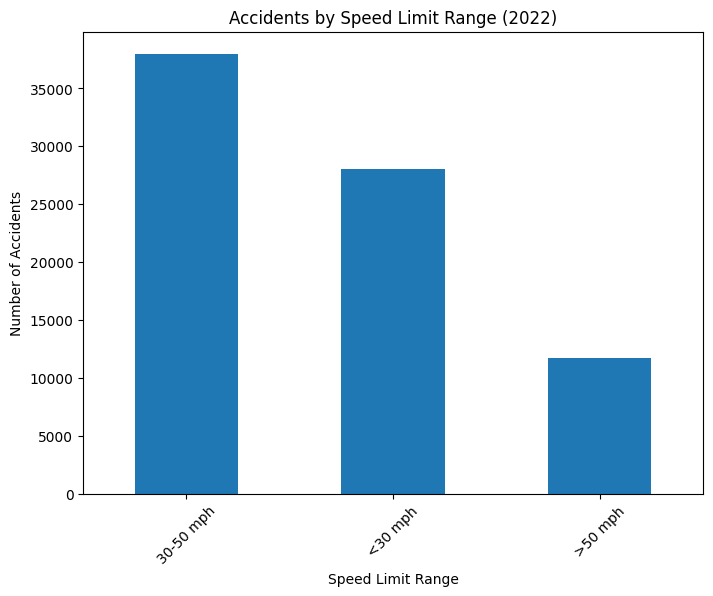

In [ ]:
# Plot accident frequencies
plt.figure(figsize=(8, 6))
accidents_by_speed_range.plot(kind='bar')
plt.title('Accidents by Speed Limit Range (2022)')
plt.xlabel('Speed Limit Range')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

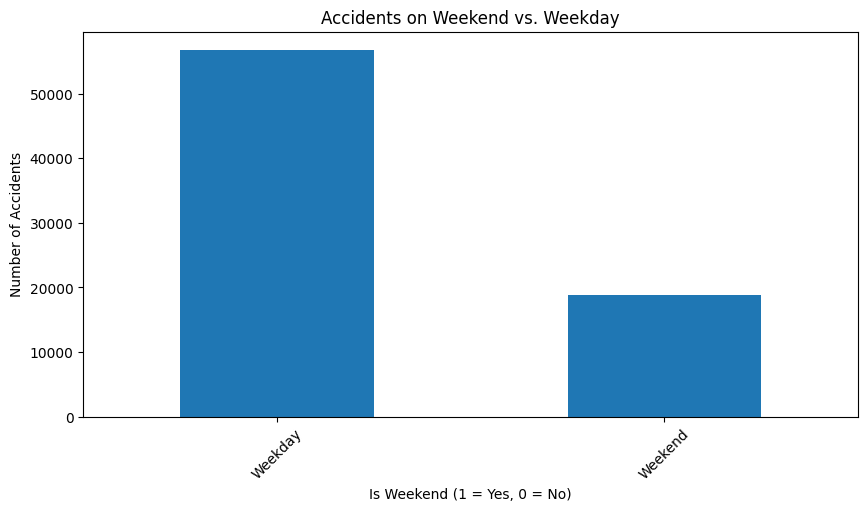

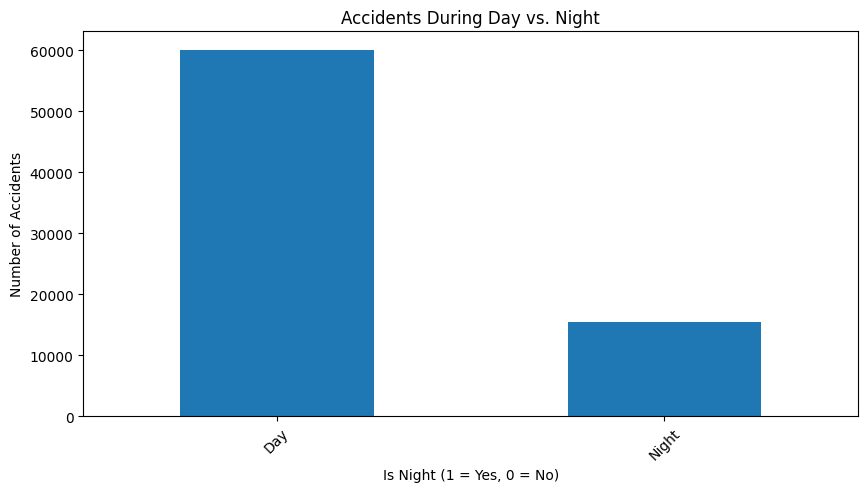

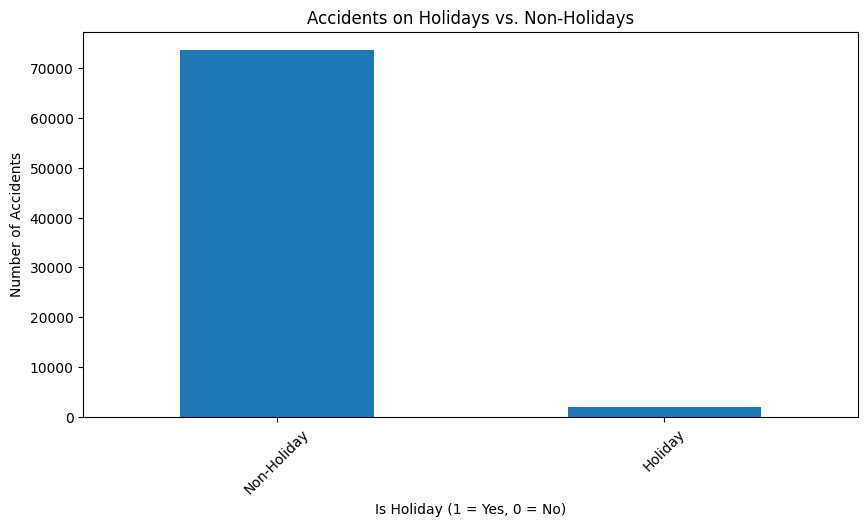

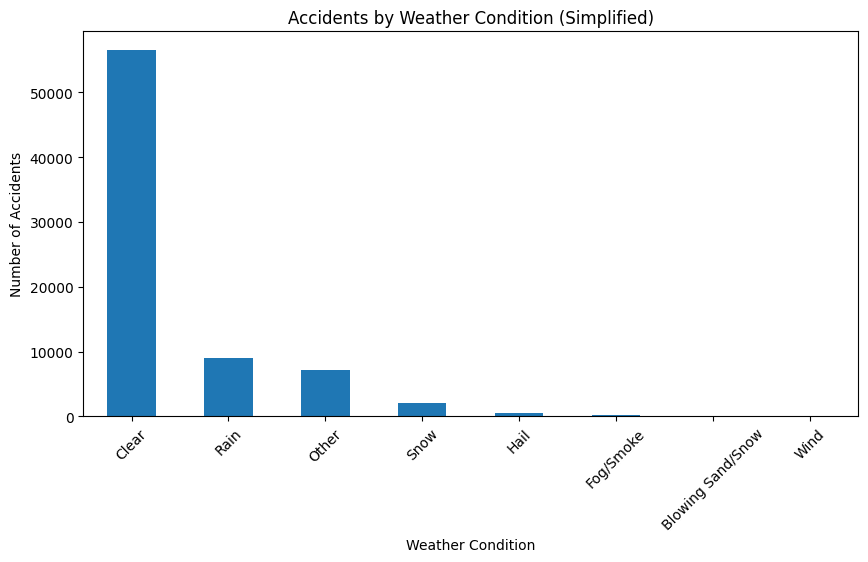

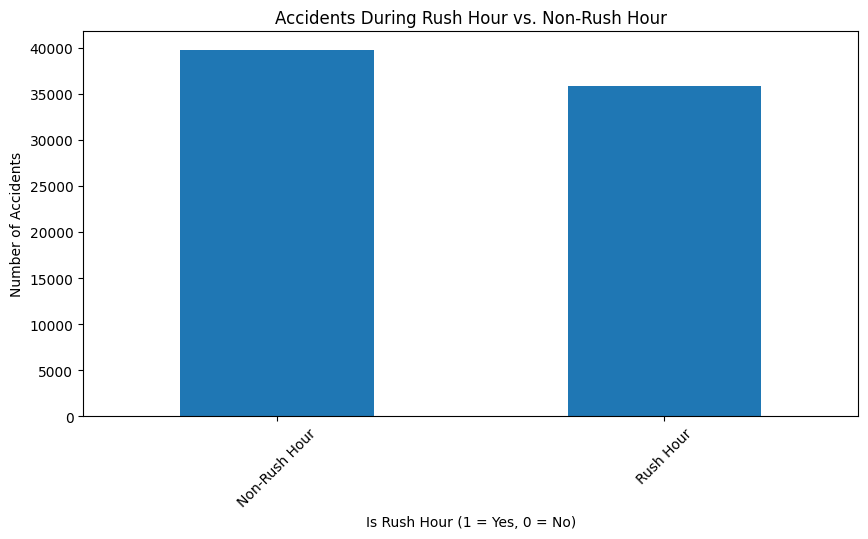

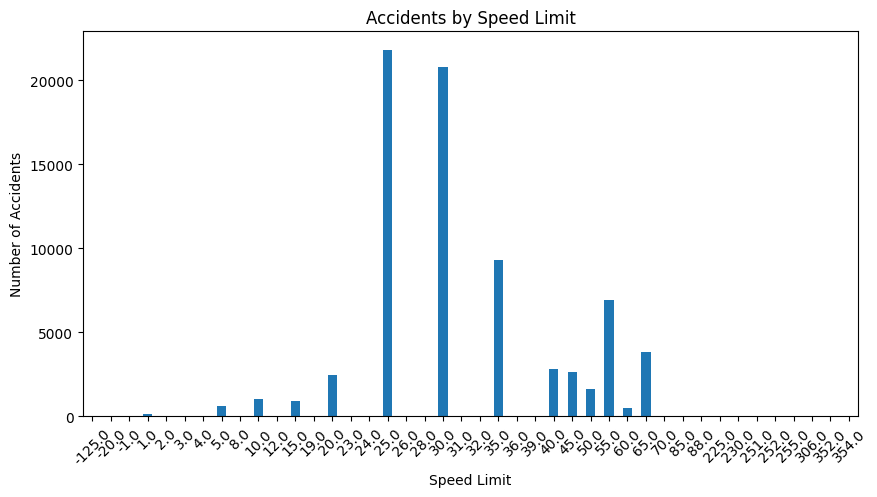

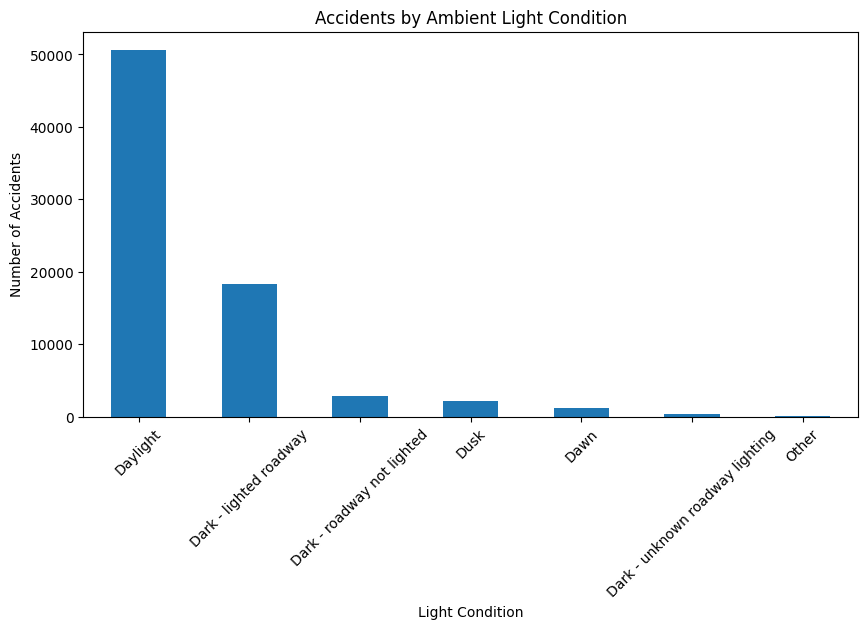

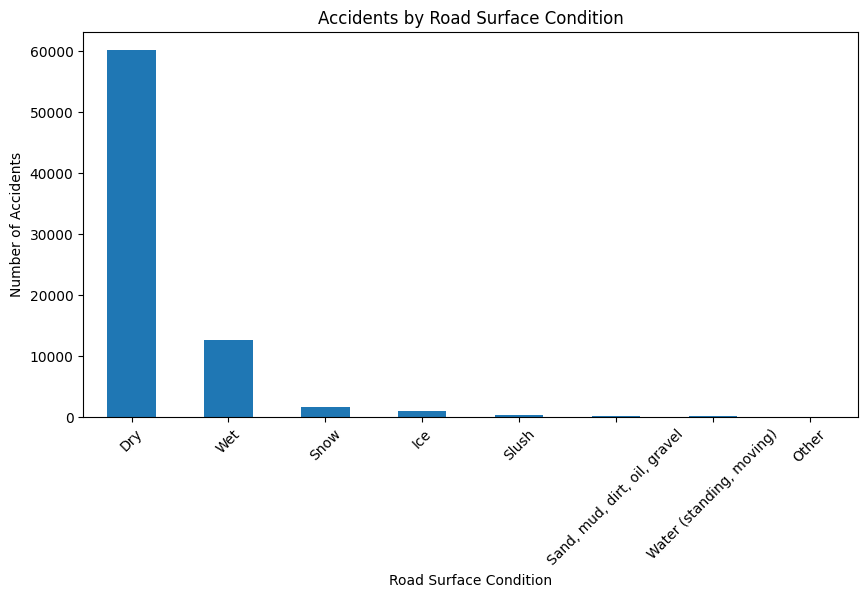

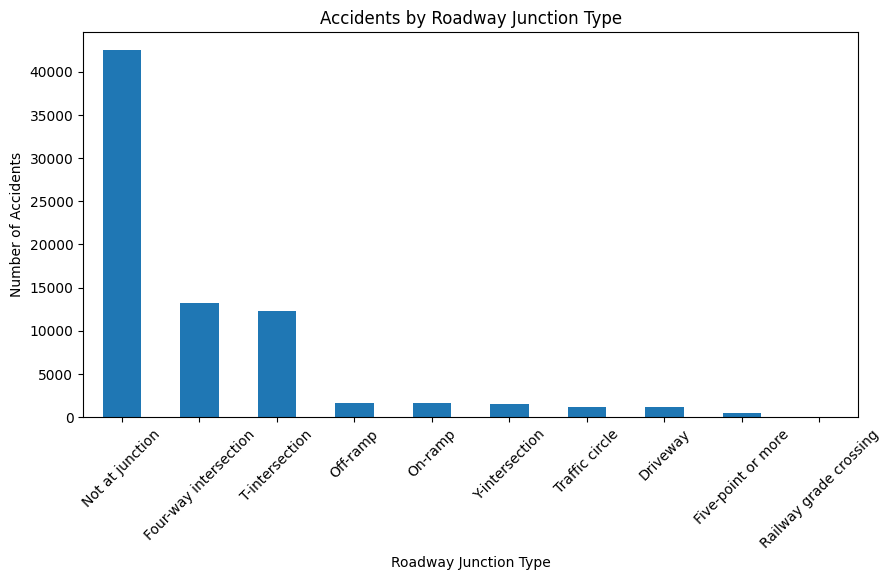

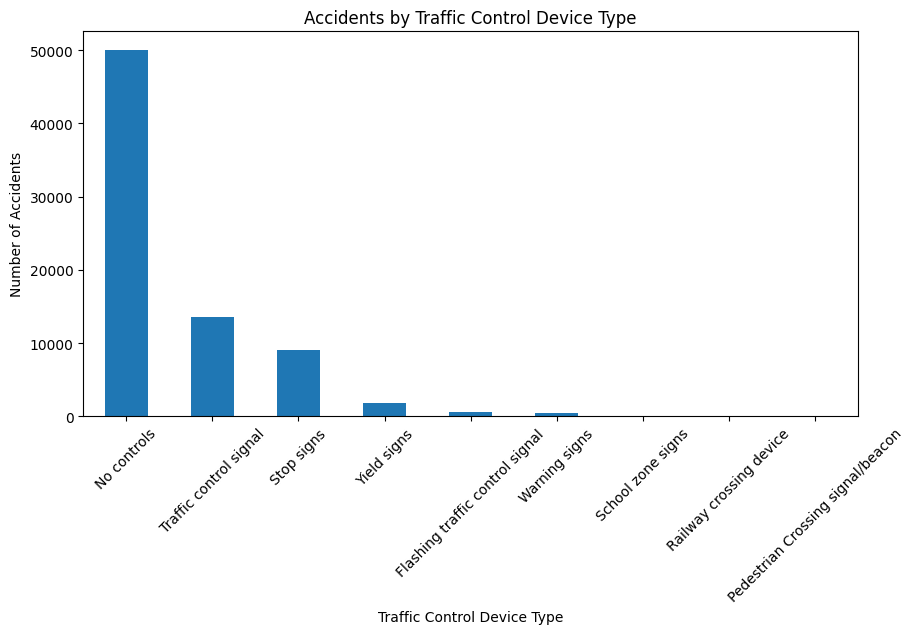

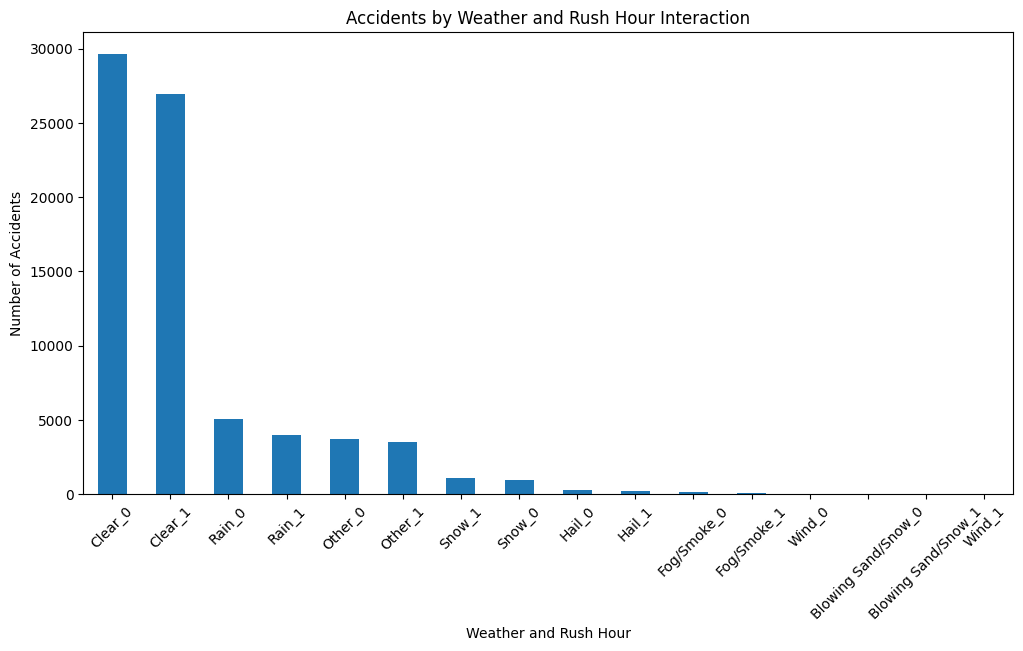

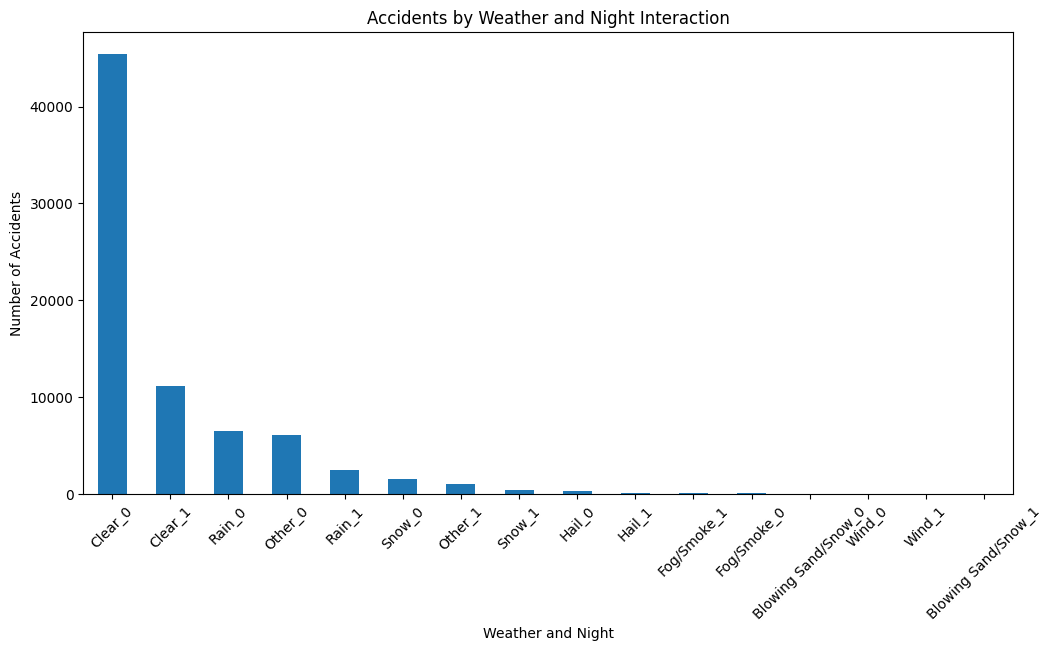

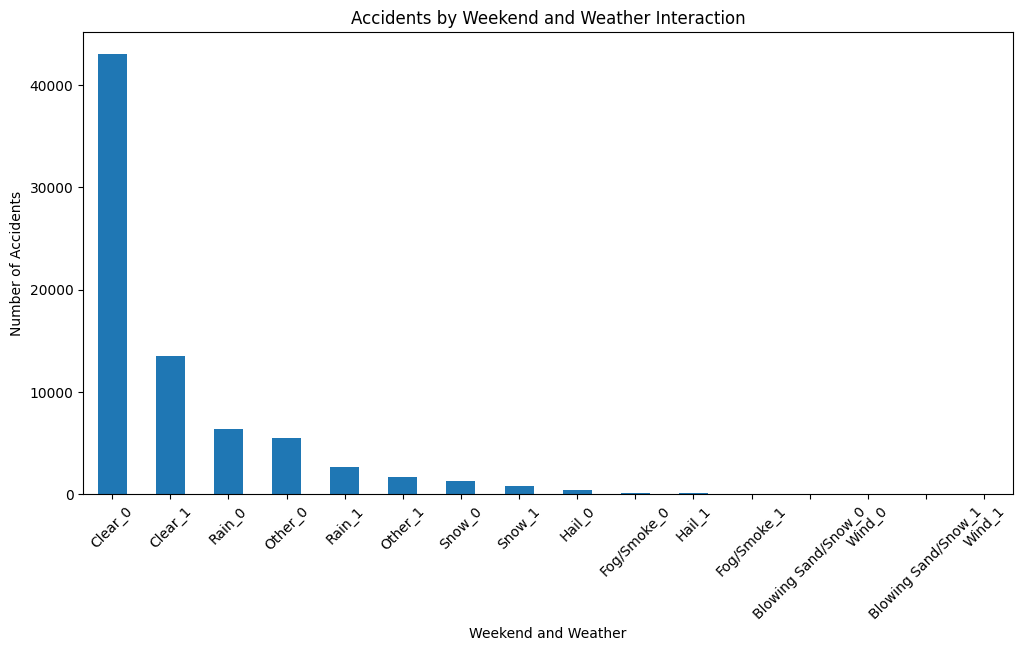

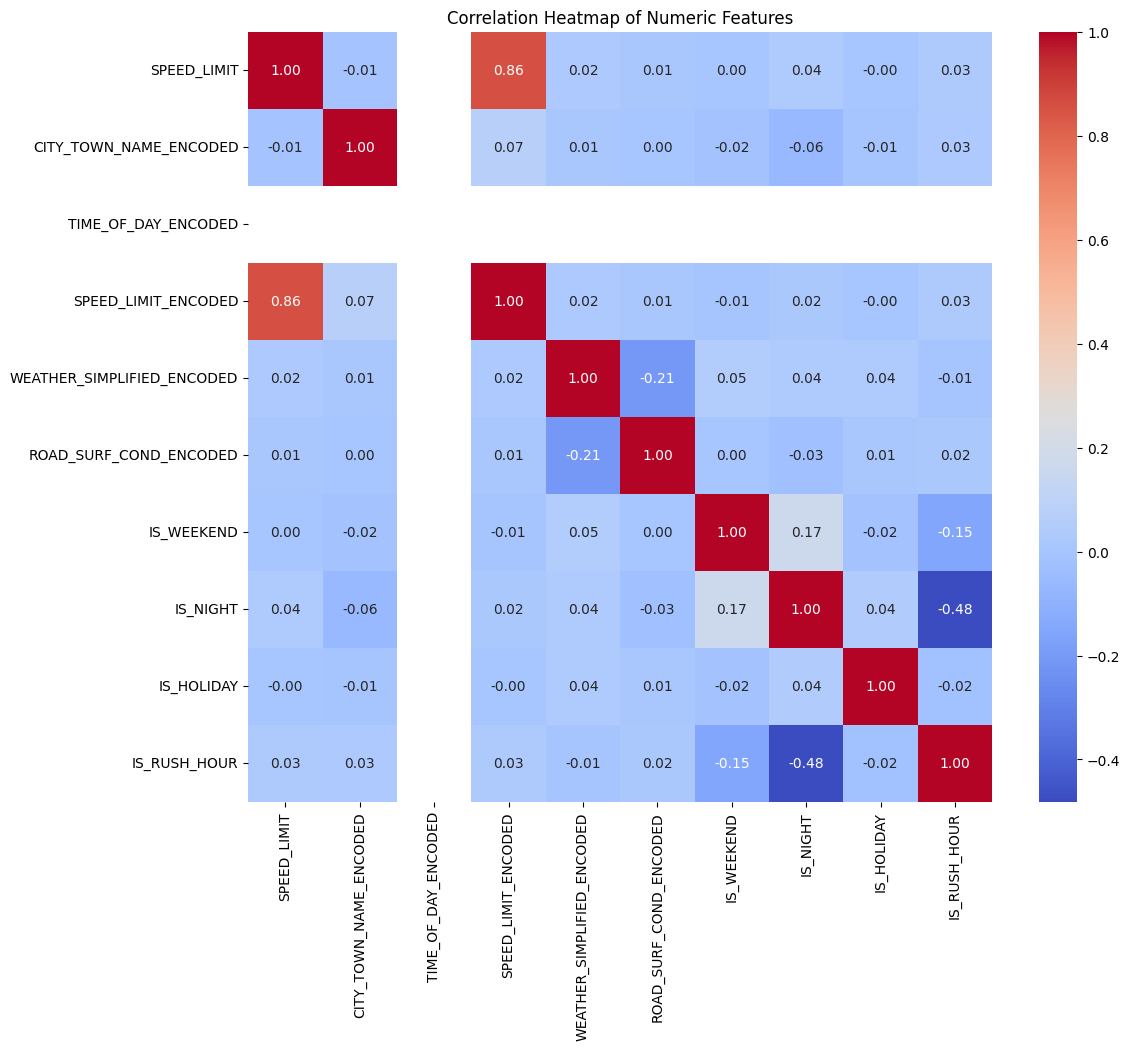

In [ ]:
def visualize_dataset(df):
    # 1. Accidents by Weekend vs. Weekday
    df['IS_WEEKEND'].value_counts().plot(kind='bar', figsize=(10, 5))
    plt.title("Accidents on Weekend vs. Weekday")
    plt.xlabel("Is Weekend (1 = Yes, 0 = No)")
    plt.ylabel("Number of Accidents")
    plt.xticks(ticks=[0, 1], labels=['Weekday', 'Weekend'], rotation=45)
    plt.show()

    # 2. Accidents During Day vs. Night
    df['IS_NIGHT'].value_counts().plot(kind='bar', figsize=(10, 5))
    plt.title("Accidents During Day vs. Night")
    plt.xlabel("Is Night (1 = Yes, 0 = No)")
    plt.ylabel("Number of Accidents")
    plt.xticks(ticks=[0, 1], labels=['Day', 'Night'], rotation=45)
    plt.show()

    # 3. Accidents on Holidays vs. Non-Holidays
    df['IS_HOLIDAY'].value_counts().plot(kind='bar', figsize=(10, 5))
    plt.title("Accidents on Holidays vs. Non-Holidays")
    plt.xlabel("Is Holiday (1 = Yes, 0 = No)")
    plt.ylabel("Number of Accidents")
    plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'], rotation=45)
    plt.show()

    # 4. Accidents by Weather Condition (Simplified)
    df['WEATHER_SIMPLIFIED'].value_counts().plot(kind='bar', figsize=(10, 5))
    plt.title("Accidents by Weather Condition (Simplified)")
    plt.xlabel("Weather Condition")
    plt.ylabel("Number of Accidents")
    plt.xticks(rotation=45)
    plt.show()

    # 5. Accidents During Rush Hour vs. Non-Rush Hour
    df['IS_RUSH_HOUR'].value_counts().plot(kind='bar', figsize=(10, 5))
    plt.title("Accidents During Rush Hour vs. Non-Rush Hour")
    plt.xlabel("Is Rush Hour (1 = Yes, 0 = No)")
    plt.ylabel("Number of Accidents")
    plt.xticks(ticks=[0, 1], labels=['Non-Rush Hour', 'Rush Hour'], rotation=45)
    plt.show()

    # 6. Accidents by Speed Limit
    if 'SPEED_LIMIT' in df.columns:
        df['SPEED_LIMIT'].value_counts().sort_index().plot(kind='bar', figsize=(10, 5))
        plt.title("Accidents by Speed Limit")
        plt.xlabel("Speed Limit")
        plt.ylabel("Number of Accidents")
        plt.xticks(rotation=45)
        plt.show()

    # 7. Accidents by Light Condition
    if 'AMBNT_LIGHT_DESCR' in df.columns:
        df['AMBNT_LIGHT_DESCR'].value_counts().plot(kind='bar', figsize=(10, 5))
        plt.title("Accidents by Ambient Light Condition")
        plt.xlabel("Light Condition")
        plt.ylabel("Number of Accidents")
        plt.xticks(rotation=45)
        plt.show()

    # 8. Accidents by Road Surface Condition
    if 'ROAD_SURF_COND_DESCR' in df.columns:
        df['ROAD_SURF_COND_DESCR'].value_counts().plot(kind='bar', figsize=(10, 5))
        plt.title("Accidents by Road Surface Condition")
        plt.xlabel("Road Surface Condition")
        plt.ylabel("Number of Accidents")
        plt.xticks(rotation=45)
        plt.show()

    # 9. Accidents by Roadway Junction Type
    if 'RDWY_JNCT_TYPE_DESCR' in df.columns:
        df['RDWY_JNCT_TYPE_DESCR'].value_counts().plot(kind='bar', figsize=(10, 5))
        plt.title("Accidents by Roadway Junction Type")
        plt.xlabel("Roadway Junction Type")
        plt.ylabel("Number of Accidents")
        plt.xticks(rotation=45)
        plt.show()

    # 10. Accidents by Traffic Control Device Type
    if 'TRAF_CNTRL_DEVC_TYPE_DESCR' in df.columns:
        df['TRAF_CNTRL_DEVC_TYPE_DESCR'].value_counts().plot(kind='bar', figsize=(10, 5))
        plt.title("Accidents by Traffic Control Device Type")
        plt.xlabel("Traffic Control Device Type")
        plt.ylabel("Number of Accidents")
        plt.xticks(rotation=45)
        plt.show()

    # 11. Accidents by Weather and Rush Hour Interaction
    if 'WEATHER_RUSH_HOUR' in df.columns:
        df['WEATHER_RUSH_HOUR'].value_counts().plot(kind='bar', figsize=(12, 6))
        plt.title("Accidents by Weather and Rush Hour Interaction")
        plt.xlabel("Weather and Rush Hour")
        plt.ylabel("Number of Accidents")
        plt.xticks(rotation=45)
        plt.show()

    # 12. Accidents by Weather and Night Interaction
    if 'WEATHER_NIGHT' in df.columns:
        df['WEATHER_NIGHT'].value_counts().plot(kind='bar', figsize=(12, 6))
        plt.title("Accidents by Weather and Night Interaction")
        plt.xlabel("Weather and Night")
        plt.ylabel("Number of Accidents")
        plt.xticks(rotation=45)
        plt.show()

    # 13. Accidents by Weekend and Weather Interaction
    if 'WEATHER_WEEKEND' in df.columns:
        df['WEATHER_WEEKEND'].value_counts().plot(kind='bar', figsize=(12, 6))
        plt.title("Accidents by Weekend and Weather Interaction")
        plt.xlabel("Weekend and Weather")
        plt.ylabel("Number of Accidents")
        plt.xticks(rotation=45)
        plt.show()

    # 14. Correlation Heatmap for Numeric Features
    numeric_df = df.select_dtypes(include=['int64', 'float64'])
    if not numeric_df.empty:
        plt.figure(figsize=(12, 10))
        sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
        plt.title("Correlation Heatmap of Numeric Features")
        plt.show()

# Visualize the merged dataset
visualize_dataset(merged_df)

###  Visualize Accident Frequencies

## Modeling

In [ ]:
# Drop Visualization Columns
 #'TIME_WEATHER', 'HOLIDAY_RUSH', 'SPEED_WEATHER'
merged_df = merged_df.drop(columns=['F_CLASS', 'SPEED_LIMIT_RANGE', 'CNTY_NAME', 'WEATHER_RUSH_HOUR', 'WEATHER_NIGHT', 'WEATHER_WEEKEND', 'WEATHER_SIMPLIFIED', 'TERRAIN', 'CONTROL', 'OPERATION', 'TRAF_CNTRL_DEVC_TYPE_DESCR', 'AGE_DRVR_YNGST', 'AGE_DRVR_OLDEST', 'RDWY_JNCT_TYPE_DESCR', 'CITY_TOWN_NAME', 'CRASH_DATE_TEXT', 'CRASH_TIME_2', 'CRASH_DATETIME', 'AMBNT_LIGHT_DESCR', 'WEATH_COND_DESCR', 'ROAD_SURF_COND_DESCR'])

### Train, Test and Model Selection

In [ ]:
merged_df.head(1).T

,3
CRASH_HOUR,11.0
SPEED_LIMIT,30.0
CITY_TOWN_NAME_ENCODED,15.0
TIME_OF_DAY_ENCODED,3.0
SPEED_LIMIT_ENCODED,1.0
WEATHER_SIMPLIFIED_ENCODED,5.0
ROAD_SURF_COND_ENCODED,0.0
DAY_OF_WEEK,5.0
IS_WEEKEND,1.0
IS_NIGHT,0.0


In [ ]:
# Ensure 'ACCIDENT_OCCURRENCE' is present in merged_df
merged_df['ACCIDENT_OCCURRENCE'] = 1  # Assuming all rows in df_2023 represent actual accidents

In [ ]:
def generate_synthetic_data_with_weights(reference_df, num_samples):
    # Weighted distributions based on crash likelihood
    weather_weights = {
        0: 0.7,  # Clear
        1: 0.2,  # Rain
        2: 0.05,  # Snow
        3: 0.05   # Fog/Smoke
    }
    time_of_day_weights = {
        0: 0.2,  # Night
        1: 0.3,  # Morning
        2: 0.3,  # Afternoon
        3: 0.2   # Evening
    }
    road_surface_weights = {
        0: 0.8,  # Dry
        1: 0.15,  # Wet
        2: 0.02,  # Ice
        3: 0.01,  # Snow
        4: 0.01,  # Slush
        5: 0.01   # Other
    }
    speed_limit_weights = {
        0: 0.5,  # <30 mph
        1: 0.4,  # 30-50 mph
        2: 0.1   # >50 mph
    }

    # Generate synthetic data with weighted probabilities
    synthetic_data = pd.DataFrame({
        'CRASH_HOUR': np.random.choice(reference_df['CRASH_HOUR'].unique(), num_samples),
        'CITY_TOWN_NAME_ENCODED': np.random.choice(reference_df['CITY_TOWN_NAME_ENCODED'].unique(), num_samples),
        'TIME_OF_DAY_ENCODED': np.random.choice(reference_df['TIME_OF_DAY_ENCODED'].unique(), num_samples),
        'TIME_OF_DAY_ENCODED': np.random.choice( #Corrected indentation here
            list(time_of_day_weights.keys()), num_samples,
            p=list(time_of_day_weights.values())
        ),
        'SPEED_LIMIT_ENCODED': np.random.choice( #Corrected indentation here
            list(speed_limit_weights.keys()), num_samples,
            p=list(speed_limit_weights.values())
        ),
        'WEATHER_SIMPLIFIED_ENCODED': np.random.choice( #Corrected indentation here
            list(weather_weights.keys()), num_samples,
            p=list(weather_weights.values())
        ),
        'ROAD_SURF_COND_ENCODED': np.random.choice( #Corrected indentation here
            list(road_surface_weights.keys()), num_samples,
            p=list(road_surface_weights.values())
        ),
        'DAY_OF_WEEK': np.random.choice(reference_df['DAY_OF_WEEK'].unique(), num_samples),
        'IS_WEEKEND': np.random.choice([0, 1], num_samples, p=[0.8, 0.2]),
        'IS_NIGHT': np.random.choice([0, 1], num_samples, p=[0.3, 0.7]),
        'IS_HOLIDAY': np.random.choice([0, 1], num_samples, p=[0.9, 0.1]),
        'IS_RUSH_HOUR': np.random.choice([0, 1], num_samples, p=[0.7, 0.3]),
        'ACCIDENT_OCCURRENCE': 0  # Set to 0 for synthetic non-accidents
    })

    return synthetic_data

In [ ]:
print(merged_df['DAY_OF_WEEK'].unique())

[5 0 6 2 1 3 4]


In [ ]:
num_samples = len(merged_df)
synthetic_data = generate_synthetic_data_with_weights(merged_df, num_samples)

# Combine the original dataset with the synthetic dataset
combined_df = pd.concat([merged_df, synthetic_data], ignore_index=True)

# Shuffle the combined dataset
shuffled_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Perform a train-test split
X = shuffled_df.drop(columns=['ACCIDENT_OCCURRENCE'])  # Features
y = shuffled_df['ACCIDENT_OCCURRENCE']  # Target variable

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print(f"Train Features Shape: {X_train.shape}")
print(f"Train Target Shape: {y_train.shape}")
print(f"Test Features Shape: {X_test.shape}")
print(f"Test Target Shape: {y_test.shape}")


Train Features Shape: (120929, 11)
Train Target Shape: (120929,)
Test Features Shape: (30233, 11)
Test Target Shape: (30233,)


In [ ]:
# Import necessary libraries
import numpy as np
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Fix for deprecated np.int
if not hasattr(np, 'int'):
    np.int = int

# Random Forest with Bayesian Optimization
rf_bayes = BayesSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    search_spaces={
        'n_estimators': (50, 200),
        'max_depth': (5, 20),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 5)
    },
    scoring='f1_weighted',
    cv=3,
    n_iter=20,
    random_state=42
)
rf_bayes.fit(X_train, y_train)
best_rf = rf_bayes.best_estimator_

# Gradient Boosting with Grid Search
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
gb_model = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=gb_params,
    scoring='f1_weighted',
    cv=3
)
gb_model.fit(X_train, y_train)
best_gb = gb_model.best_estimator_

# XGBoost
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Neural Network
def build_nn(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

nn_model = build_nn(X_train.shape[1])
nn_model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=32, callbacks=[EarlyStopping(patience=5)])

# Stacking Model
stacking_model = StackingClassifier(
    estimators=[
        ('rf', best_rf),
        ('gb', best_gb),
        ('xgb', xgb_model)
    ],
    final_estimator=LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)
)
stacking_model.fit(X_train, y_train)

# Calibration for Final Models
calibrated_rf = CalibratedClassifierCV(best_rf, method='isotonic', cv=3)
calibrated_rf.fit(X_train, y_train)

calibrated_gb = CalibratedClassifierCV(best_gb, method='sigmoid', cv=3)
calibrated_gb.fit(X_train, y_train)

# Evaluate Final Models
models = {
    "Calibrated RF": calibrated_rf,
    "Calibrated GB": calibrated_gb,
    "Stacking Model": stacking_model
}
for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{name}: Accuracy = {accuracy:.4f}, F1 Score = {f1:.4f}")


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3024/3024 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7875 - loss: 0.5843 - val_accuracy: 0.9767 - val_loss: 0.0755
Epoch 2/30
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9689 - loss: 0.0960 - val_accuracy: 0.9810 - val_loss: 0.0529
Epoch 3/30
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9772 - loss: 0.0679 - val_accuracy: 0.9864 - val_loss: 0.0388
Epoch 4/30
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9801 - loss: 0.0590 - val_accuracy: 0.9857 - val_loss: 0.0389
Epoch 5/30
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9823 - loss: 0.0526 - val_accuracy: 0.9871 - val_loss: 0.0372
Epoch 6/30
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9827 - loss: 0.0502 - val_accuracy: 0.9895 - val_loss: 0.0280
Epoch 7/30
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9843 - loss: 0.0470 - val_accuracy: 0.9832 - val_loss: 0.0456
Epoch 8/30
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9850 - loss: 0.0447 - val_accu

In [ ]:
# Calculate the baseline accuracy (naïve rule)
majority_class = y_train.mode()[0]
baseline_accuracy = (y_test == majority_class).mean()
print(f"Baseline Accuracy (Naïve Rule): {baseline_accuracy:.4f}")

Baseline Accuracy (Naïve Rule): 0.4988


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Example with calibrated RF
y_pred_rf = calibrated_rf.predict(X_test)
print("Confusion Matrix (Calibrated RF):")
print(confusion_matrix(y_test, y_pred_rf))
print("Classification Report (Calibrated RF):")
print(classification_report(y_test, y_pred_rf))

Confusion Matrix (Calibrated RF):
[[14975   105]
 [   57 15096]]
Classification Report (Calibrated RF):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     15080
           1       0.99      1.00      0.99     15153

    accuracy                           0.99     30233
   macro avg       0.99      0.99      0.99     30233
weighted avg       0.99      0.99      0.99     30233



In [ ]:
import joblib

# Save the calibrated RF model to a file
joblib.dump(calibrated_rf, 'calibrated_rf_model.joblib')

print("Model saved successfully as 'calibrated_rf_model.joblib'")


Model saved successfully as 'calibrated_rf_model.joblib'


## Visualization of Results and Insights

### Feature Importance for Random Forest (To Understand Key Predictors)

Visualizing results for the Best Model...


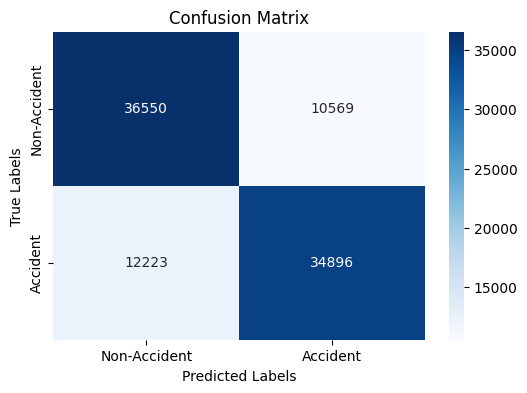

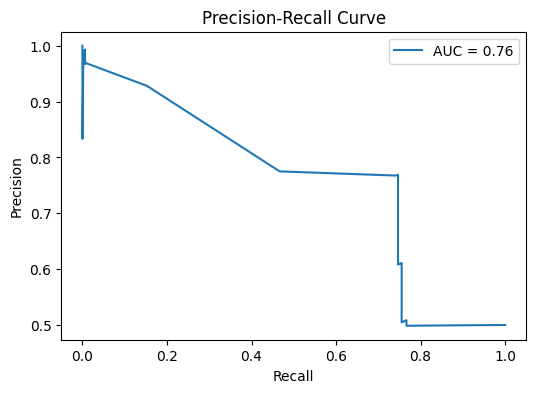

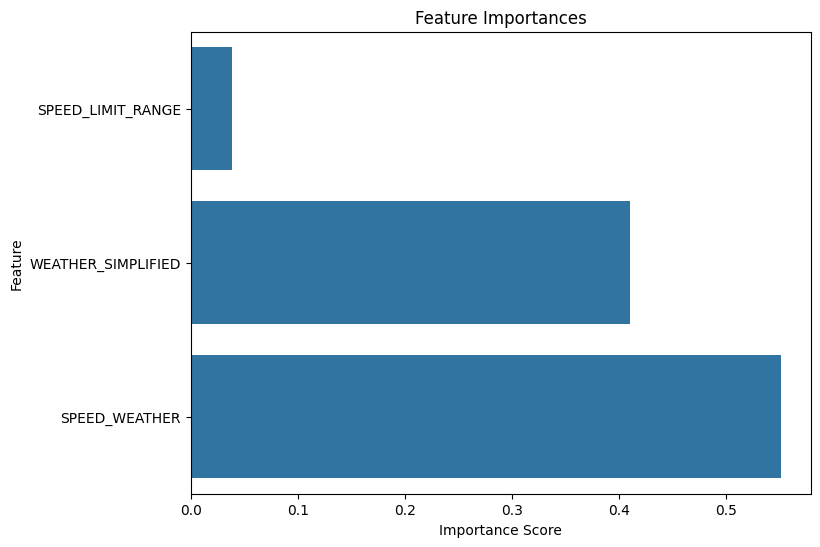

In [ ]:
# Step 1: Plot Confusion Matrix
def plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Accident', 'Accident'], yticklabels=['Non-Accident', 'Accident'])
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Step 2: Plot Precision-Recall Curve
def plot_precision_recall_curve(y_test, y_pred_proba, title="Precision-Recall Curve"):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    auc_score = auc(recall, precision)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label=f"AUC = {auc_score:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.show()

# Step 3: Plot Feature Importances (only for models with feature_importances_)
def plot_feature_importances(model, feature_names, title="Feature Importances"):
    if hasattr(model, "feature_importances_"):
        feature_importances = model.feature_importances_
        plt.figure(figsize=(8, 6))
        sns.barplot(x=feature_importances, y=feature_names)
        plt.title(title)
        plt.xlabel("Importance Score")
        plt.ylabel("Feature")
        plt.show()


# Assuming `best_model` is your chosen model
print("Visualizing results for the Best Model...")

# Assuming best_model is your trained model
y_pred = (best_model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix for Best Model")

# Precision-Recall Curve
plot_precision_recall_curve(y_test, y_pred_proba, title="Precision-Recall Curve for Best Model")

# Feature Importances
plot_feature_importances(best_model, ['SPEED_LIMIT_RANGE', 'WEATHER_SIMPLIFIED', 'SPEED_WEATHER'], title="Feature Importances for Best Model")

### Isotonic Calibration for Probability Adjustments

In [ ]:
# Isotonic calibration for Random Forest
rf_calibrated = CalibratedClassifierCV(rf_bayes.best_estimator_, method='isotonic', cv=5)
rf_calibrated.fit(X_train, y_train)

# Evaluate calibrated model
y_pred_proba_rf = rf_calibrated.predict_proba(X_test)[:, 1]
print("Calibrated probabilities:", y_pred_proba_rf[:10])

## Save the Processed Data (Final)

In [ ]:
## Submission

# Generate predictions for submission
df_test_balanced['PREDICTED_PROBABILITY'] = best_model.predict_proba(X_test)[:, 1]
df_test_balanced['PREDICTED_LABEL'] = (df_test_balanced['PREDICTED_PROBABILITY'] >= 0.5).astype(int)

# Optional: Filter only predictions with label 1 (accidents)
filtered_df = df_test_balanced[df_test_balanced['PREDICTED_LABEL'] == 1]

# Save to submissions.csv
filtered_df[['PREDICTED_LABEL', 'PREDICTED_PROBABILITY']].to_csv('submissions.csv', index=False)
print("Submission file has been generated: submissions.csv")